# Synchronised backpropagaton

The aim of this notebook is to apply backpropagation to the signals measured by an impedance head. We try to adapt the backpropagation model at regular time intervals, based on measurements of broadband sound that are simulatneous to the glide under study.

## Requires:

* PyPeVoc: https://github.com/goiosunsw/PyPeVoc
* ImpedancePython: https://github.com/goiosunsw/ImpedancePython
* audacity.py: https://github.com/goiosunsw/audacity.py
* multi_optimiser: should be in the same folder as this file

In [2]:
import os
import numpy as np
import matplotlib.pyplot as pl
import pandas
%matplotlib inline
from scipy.io.matlab import loadmat
from scipy.signal import argrelmax

# for reading audacity projects
import audacity
# for calculations of impedance from geometry
import pympedance.Synthesiser as psyn
# for reading UNSW impedance measurements and calibrations
import pympedance.UNSW as pun
# for harmonic detection
from pypevoc import PV
# for chunk segmentation
import pypevoc.speech.SpeechChunker as schunk


# function to plot imaginary transfer functions
from pympedance.plot_utils import bodeplot
# utilities to manage optimisation
from multi_optimiser import FunctionFitter

# Optimisation functions

Function to determine peaks. 

Not used in this notebook, but could be useful to rewrite the cost function based on peaks only. This might work better in measurement during phonation, but it does not seem necessary here.

In [3]:
def pk_param(x,y,rad=1):
    allmax = argrelmax(y,order=rad)[0]
    idmax = np.ones(len(allmax))
    allmin = argrelmax(-y,order=rad)[0]
    idmin = -np.ones(len(allmin))


    extu = np.concatenate((allmax,allmin))
    idxext = np.argsort(extu)
    allext = extu[idxext]
    allid = np.concatenate((idmax,idmin))[idxext]
    extdict = []

    dx = np.median(np.diff(x))
    for ii, (tp, xx) in enumerate(zip(allid,allext)):
        val = y[xx]
        
        # quadratic interpolation 
        pos = x[xx]
        if xx>0 and xx<len(x)-1:
            c = y[xx]
            b = (y[xx+1] - y[xx-1])/2
            a = (y[xx+1] + y[xx-1])/2 - c
            dxx = -b/2/a
            pos -= dxx*dx
            val = a*dxx**2 + b*dxx + c
        
        thisdict={'pos':pos,
                  'val':val,
                  'type':tp}

        sal_l = sal_r = np.max(allext)-np.min(allext)
        if ii>0:
            sal_l = (val-y[allext[ii-1]])*tp
        if ii<len(allext)-1:
            sal_r = (val-y[allext[ii+1]])*tp
        thisdict['sal']=min(sal_l,sal_r)
        extdict.append(thisdict)
    return extdict



Functions that calculate differences

`logzdiff` is used in the optimisations done in this notebook, which treats impedance values at all frequencies equally. You can also rewrite this function if you want to give more relevance to peaks, or particular parts of the pspectrum

`pkdiff` would be used in an optimisation based on peaks only

In [4]:
def logzdiff(f,z1,z2):
    z1db = 20*np.log10(np.abs(z1))
    z2db = 20*np.log10(np.abs(z2))
    dbdiff = z1db-z2db
    return np.sqrt(np.sum(dbdiff**2))
    

def pkdiff(f,z1,z2):
    pks1 = pk_param(f,20*np.log10(np.abs(z1)),rad=40)
    pks2 = pk_param(f,20*np.log10(np.abs(z2)),rad=40)
    posdiff=np.zeros(len(pks1))
    valdiff=np.zeros(len(pks1))

    #pks1 = [pk for pk in pks1 if np.sign(pk['type'])==np.sign(typ)]
    #pks2 = [pk for pk in pks2 if np.sign(pk['type'])==np.sign(typ)]
    # find nearest
    for ii, pk1 in enumerate(pks1): 
        sel = np.array([ii for ii,pk2 in enumerate(pks2) if pk2['type'] == pk1['type']])
        pks2pos = np.array([pks2[ii]['pos'] for ii in sel])
        pk1pos = pk1['pos']
        idx = np.argmin(np.abs(pk1pos-pks2pos))
        pk2pos = pks2pos[idx]
        posdiff[ii] = (2*(pk1pos-pk2pos)/(pk1pos+pk2pos))
        valdiff[ii] = (pk1['val']-pks2[sel[idx]]['val'])*pk1['type']
    
    # return np.sqrt(np.sum(np.array(posdiff)**2)), np.sqrt(np.sum(np.array(valdiff)**2))
    return posdiff, valdiff



Function to convert from geometry parameters to optimiser parameters. Needed because the optimiser requires a function that takes a list of arguments (and not a dict, or a complicated object such as the duct construction functions)

In [5]:
def argdict_to_duct(**kwargs):
    loss_mult = kwargs['loss_mult']
    is_rigid = True
    try:
        compl = kwargs['compliance']
        is_rigid = False
    except KeyError:
        compl = None
    try:
        inert = kwargs['inertance']
        is_rigid = False
    except KeyError:
        inert = None
    try:
        resist = kwargs['resistance']
        is_rigid = False
    except KeyError:
        resist = None
    
    duct = psyn.Duct()
    
    ii=0
    while True:
        duct_dict = {}
        try:
            duct_dict['length'] = kwargs['length_%d'%ii]
            duct_dict['radius'] = kwargs['radius_%d'%ii]
            radius=duct_dict['radius']
            duct_dict['loss_multiplier'] = loss_mult
        except KeyError:
            break
        if is_rigid:
            duct.append_element(psyn.StraightDuct(**duct_dict))
        else:
            duct_dict['compliance'] = compl
            duct_dict['inertance'] = inert
            duct_dict['resistance'] = resist
            duct.append_element(psyn.StraightDuctWithParallel(**duct_dict))
        ii+=1
            

    term = kwargs['term']
    if term == 'open':
        duct.set_termination(psyn.FlangedPiston(radius=radius))
    elif term == 'closed':
        duct.set_termination(psyn.PerfectClosedEnd())
    return duct

def func_cf(x, **kwargs):
    duct = argdict_to_duct(**kwargs)
    return duct.get_input_impedance_at_freq(x)

def logf_cf(x,**kwargs):
    z = func_cf(x,**kwargs)
    return 20*np.log10(np.abs(z))

Change the next line for the appropraite file locations

In [6]:
datadir = '/media/goios/ANDREDATA2/Data/20190412 - newChannels'

# This file will be used to generate a first estimation of the vocal tract geometry
initial_vt_impedance_measurement_file = os.path.join(datadir,'meas/aa_@_glotclose.mat')

# glide recording
glide_audacity_file = os.path.join(datadir, '2858mm_aa_bb.aup')

# channels id
mic_channel_numbers = [1,2]
egg_channel_number = 3

# 1. Read an impedance measurement without phonation

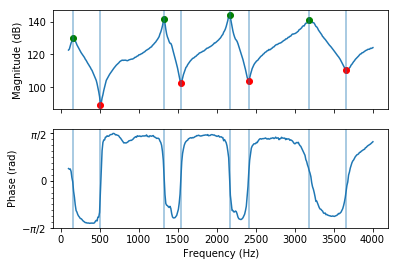

In [7]:
imp0 = pun.ImpedanceMeasurement(initial_vt_impedance_measurement_file)
fig,ax=bodeplot(imp0.f,imp0.z);

# This calculates peak positions (not used at present)
pks = pk_param(imp0.f,20*np.log10(np.abs(imp0.z)),rad=10)
for pk in pks:
    if pk['type']>0:
        color='g'
    else:
        color='r'
    ax[0].plot(pk['pos'],pk['val'],color=color,marker='o')
    ax[0].axvline(pk['pos'],alpha=.5)
    ax[1].axvline(pk['pos'],alpha=.5)

## Vocal tract fitting

Fits a geometry to the impedance curve.

We start by dividing the tract into $N$ segments with equal lengths and radii, with the radius of the impedance head. This makes the initial guess a straight pipe 17cm long. 

The best value of $N$ (`n_seg`) has been found at 8 in general, but other values can be tried

Fit is saved to a csv file that can be used later if broadband noise is not injeted

**NB** there are also duct segments with flexible walls, but for now the parameters in them are absolute, which means that when the length of the segment is changed, the compliance, inertance and resistance also have to be scaled. This makes it impratical for now to do an overal fit on a general wall complaince for example. 

In [8]:

# initial parameters (general)
argdict = {'loss_mult':5., 'term':'closed'}#,'inertance':2e3,'compliance':2e-9,'resistance':2e5}
# boundaries for fitted parameters
bounds = {'loss_mult':[.1,20.], 'term':None}#,'inertance':[0,np.inf],'compliance':[0,np.inf],'resistance':[0,np.inf]}

# minimum frequency used in the fit
fmin=100.
idx = imp0.f>fmin

## overal initial geometric parameters
# total length
ltot=170
# number of segments to fit
n_seg=8

## Creates the initial geometric parameters per segment
l = np.ones(n_seg)*ltot/n_seg
d = np.ones(n_seg)*26

for ii, (ll, dd) in enumerate(zip(l,d)):
    argdict['length_%d'%ii]=ll/1000
    bounds['length_%d'%ii]=np.array([.5,2.0])*ll/1000
    argdict['radius_%d'%ii]=dd/2000
    bounds['radius_%d'%ii]=np.array([.001,.1])
    
## mask sets the parameters that are to be fitted (or to be kept constant)
mask = {k:True for k in argdict.keys()}
# keep the duct termination closed
mask['term']=False

## the actual fitting object
ff=FunctionFitter(logf_cf, imp0.f[idx], 20*np.log10(np.abs(imp0.z[idx])), pardict=argdict,bounds=bounds)
ff.apply_mask_dict(mask)
#print(ff.free_params)
init_params = ff.arg_list_to_dict(ff.vals)
# the actual fitting
ff.fit()
print ("{:20s}:{:>20s},{:>20s}".format('parameter','initial','fitted'))

for parname in ff.free_params:
    print("{:20s}:{:20f},{:20f}".format(parname,init_params[parname],ff.vals_fit[parname]))
    
   

/home/goios/Envs/unsw/lib/python3.6/site-packages/pympedance-0.1-py3.6.egg/pympedance/Synthesiser.py:1004: RuntimeWarning: divide by zero encountered in true_divide
  return (1.+r)/(1.-r)


parameter           :             initial,              fitted
loss_mult           :            5.000000,            5.536044
length_0            :            0.021250,            0.010625
radius_0            :            0.013000,            0.007869
length_1            :            0.021250,            0.024004
radius_1            :            0.013000,            0.012225
length_2            :            0.021250,            0.040760
radius_2            :            0.013000,            0.015369
length_3            :            0.021250,            0.010625
radius_3            :            0.013000,            0.012372
length_4            :            0.021250,            0.010625
radius_4            :            0.013000,            0.019827
length_5            :            0.021250,            0.031881
radius_5            :            0.013000,            0.011447
length_6            :            0.021250,            0.010625
radius_6            :            0.013000,            0

Plot the impedance of the fitted tract

/home/goios/Envs/unsw/lib/python3.6/site-packages/pympedance-0.1-py3.6.egg/pympedance/Synthesiser.py:1004: RuntimeWarning: divide by zero encountered in true_divide
  return (1.+r)/(1.-r)


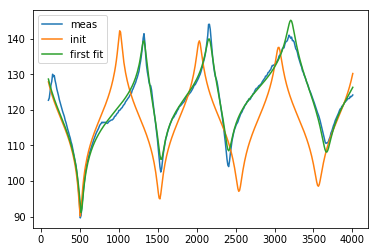

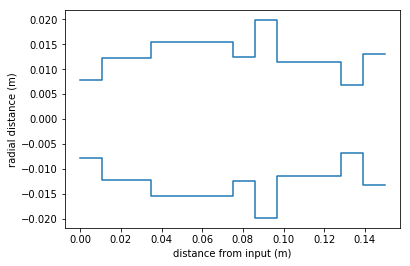

In [9]:
pl.figure()
pl.plot(imp0.f,20*np.log10(np.abs(imp0.z)),label='meas')
pl.plot(imp0.f,logf_cf(imp0.f,**argdict),label='init')

pl.plot(imp0.f,logf_cf(imp0.f,**ff.vals_fit),label='first fit')
pl.legend()

vt = argdict_to_duct(**ff.vals_fit)
vt.plot_geometry()

geom0 = ff.vals_fit 

ss=pandas.Series(ff.vals_fit)
ss.to_csv(os.path.join(datadir,os.path.split(os.path.splitext(initial_vt_impedance_measurement_file)[0])[-1]+'_geometry_fit.csv'))

# Load a glide

In [17]:
aud = audacity.Aup(glide_audacity_file)
sr=aud.rate
for reg in aud.get_annotation_data():
    print (reg)
#select a trial number
rno=2

{'start': 0.8011746317, 'end': 3.2318569888, 'label': 'pre_glide_silence_1'}
{'start': 3.4355454544, 'end': 4.8613647142, 'label': 'glide_prep_1'}
{'start': 4.8613647142, 'end': 18.2369072937, 'label': 'glide_1'}
{'start': 18.2640657558, 'end': 18.6171257629, 'label': 'post_glide_silence_1'}
{'start': 18.7257596113, 'end': 19.8664150191, 'label': 'breath_in_1'}
{'start': 20.3960050298, 'end': 21.6181358239, 'label': 'pre_glide_silence_2'}
{'start': 21.6181358239, 'end': 32.2506737323, 'label': 'glide_2'}
{'start': 32.2506737323, 'end': 32.4407829669, 'label': 'post_glide_2'}
{'start': 32.6852091257, 'end': 34.260399927, 'label': 'breath_in_2'}
{'start': 34.9393614792, 'end': 38.2255353922, 'label': 'pre_glide_silence_3'}
{'start': 39.1081854101, 'end': 51.7232910511, 'label': 'glide_3'}
{'start': 51.8183456684, 'end': 51.9812964409, 'label': 'post_glide_silence_3'}
{'start': 52.2528810618, 'end': 53.1898480039, 'label': 'breath_in_3'}
{'start': 53.800913401, 'end': 54.2354487944, 'labe

## Load a bit of recording for a pre phonation geomety estimation

This is a bit of broadband noise without phonation just before the glide starts. It has been tagged as a region in the audacity file. Check the two txt files for the annotation regions that can be imported by audacity

In [18]:
for reg in aud.get_annotation_data():
    if reg['label'].find('pre_glide_silence_%d'%rno)>-1:
        break
print(reg)

{'start': 20.3960050298, 'end': 21.6181358239, 'label': 'pre_glide_silence_2'}


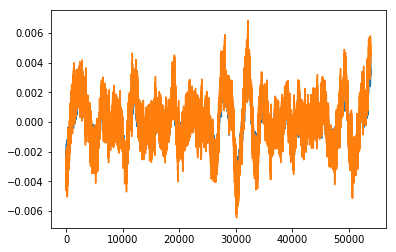

In [19]:
wmic=[]
for chno in mic_channel_numbers:
    wmic.append(aud.get_channel_data(chno,t_start=reg['start'],t_end=reg['end']))
    
wmic = np.array(wmic).T
pl.figure()
pl.plot(wmic);

## Calculate impedance from recording

From the bit of "silence" above, calculate pressure and flow using an impedance calibration

(<Figure size 432x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f862effd208>,
       dtype=object))

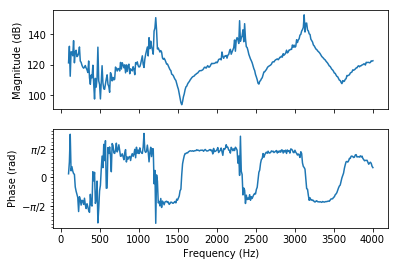

In [20]:
# get calibration and other parameters from UNSW impedance measurement
imp_params = imp0.parameters

specs = imp_params.windowed_spectrum(wmic)
mean_specs = np.mean(specs,axis=1)
err_specs = np.std(np.abs(specs),axis=1)

res = imp_params.analyse_input(mean_specs,spectral_error=err_specs[imp_params.harm_vector])
z=res['p']/res['u']

bodeplot(imp_params.frequency_vector,z)

## Refit with previous geometry as base

Initial parameters are the ones fitted above (with a long measurement of impedance). Fitting procedure is here the same as above

In [21]:
argdict = geom0

## the actual fitting object
ff=FunctionFitter(logf_cf, imp_params.frequency_vector[idx], 20*np.log10(np.abs(z[idx])).squeeze(), pardict=argdict,bounds=bounds)
ff.apply_mask_dict(mask)
#print(ff.free_params)
init_params = ff.arg_list_to_dict(ff.vals)
# the actual fitting
ff.fit()
print ("{:20s}:{:>20s},{:>20s}".format('parameter','initial','fitted'))

for parname in ff.free_params:
    print("{:20s}:{:20f},{:20f}".format(parname,init_params[parname],ff.vals_fit[parname]))
    


/home/goios/Envs/unsw/lib/python3.6/site-packages/pympedance-0.1-py3.6.egg/pympedance/Synthesiser.py:1004: RuntimeWarning: divide by zero encountered in true_divide
  return (1.+r)/(1.-r)


parameter           :             initial,              fitted
loss_mult           :            5.536044,            4.893493
length_0            :            0.010625,            0.010625
radius_0            :            0.007869,            0.008160
length_1            :            0.024004,            0.028177
radius_1            :            0.012225,            0.011998
length_2            :            0.040760,            0.010656
radius_2            :            0.015369,            0.014710
length_3            :            0.010625,            0.033250
radius_3            :            0.012372,            0.012191
length_4            :            0.010625,            0.010625
radius_4            :            0.019827,            0.009059
length_5            :            0.031881,            0.017968
radius_5            :            0.011447,            0.014467
length_6            :            0.010625,            0.026071
radius_6            :            0.006767,            0

Plot the impedance of the newly fitted tract

/home/goios/Envs/unsw/lib/python3.6/site-packages/pympedance-0.1-py3.6.egg/pympedance/Synthesiser.py:1004: RuntimeWarning: divide by zero encountered in true_divide
  return (1.+r)/(1.-r)


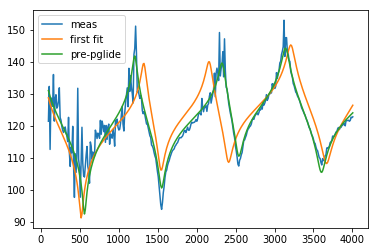

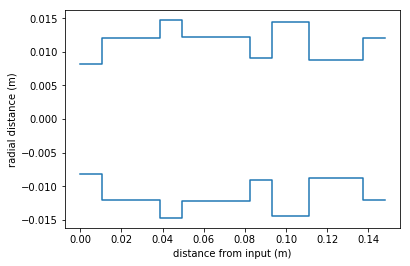

In [22]:
pl.figure()
pl.plot(imp_params.frequency_vector,20*np.log10(np.abs(z)),label='meas')
pl.plot(imp_params.frequency_vector,logf_cf(imp0.f,**argdict),label='first fit')

pl.plot(imp_params.frequency_vector,logf_cf(imp0.f,**ff.vals_fit),label='pre-pglide')
pl.legend()
vt = argdict_to_duct(**ff.vals_fit)
vt.plot_geometry()

ss=pandas.Series(ff.vals_fit)
ss.to_csv(os.path.join(datadir,os.path.split(os.path.splitext(glide_audacity_file)[0])[-1]+'_'+reg['label']+'_geometry_fit.csv'))

# Read in glide signal

{'start': 21.6181358239, 'end': 32.2506737323, 'label': 'glide_2'}


Text(0.5,0,'time (s)')

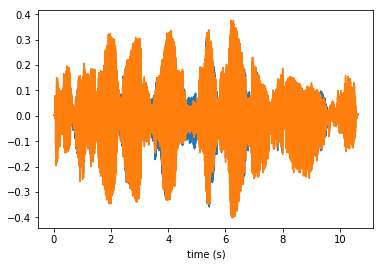

In [23]:
for reg in aud.get_annotation_data():
    if reg['label'].find('glide_%d'%rno)>-1:
        break
print(reg)

ww = []
for chno in mic_channel_numbers:
    ww.append(aud.get_channel_data(chno,t_start=reg['start'],t_end=reg['end']))
    
every=100
    
ww = np.array(ww).T
pl.figure()
pl.plot(np.arange(0,ww.shape[0],every)/sr,ww[::every,:])
pl.xlabel('time (s)')

# Harmonic extraction from microphone signals

**PV** decomposes the signal into a sum of $N$ partial sinusoidal components at regular frames

/home/goios/Envs/unsw/lib/python3.6/site-packages/pypevoc-0.1-py3.6.egg/pypevoc/PVAnalysis.py:168: RuntimeWarning: divide by zero encountered in true_divide
  frat = fx / self.oldfft
/home/goios/Envs/unsw/lib/python3.6/site-packages/pypevoc-0.1-py3.6.egg/pypevoc/PVAnalysis.py:168: RuntimeWarning: invalid value encountered in true_divide
  frat = fx / self.oldfft
/home/goios/Envs/unsw/lib/python3.6/site-packages/pypevoc-0.1-py3.6.egg/pypevoc/PVAnalysis.py:330: RuntimeWarning: divide by zero encountered in log10
  mag = 20*np.log10(self.mag)


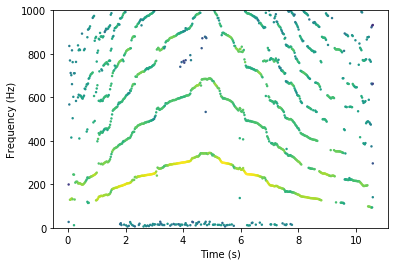

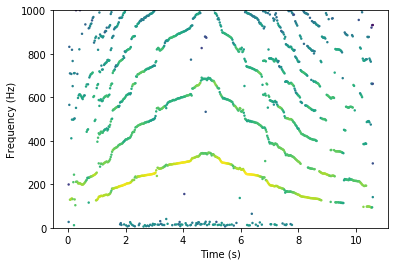

In [24]:
pva = []
mic_channels = [0,1]
for ii in mic_channels:
    wwi = ww[:,ii]
    pv = PV(wwi,sr,nfft=2**11,hop=2**10,pkthresh=1e-7)
    pv.run_pv()
    pva.append(pv)
    pv.plot_time_freq()
    pl.ylim(0,1000)

## Determine glide fundamental frequency

This is best done using the EGG signal. 

`hop` should be the same as th decomposition above so that frequency vector matches the partial amplitudes and frequencies

/home/goios/Envs/unsw/lib/python3.6/site-packages/pypevoc-0.1-py3.6.egg/pypevoc/PVAnalysis.py:168: RuntimeWarning: divide by zero encountered in true_divide
  frat = fx / self.oldfft
/home/goios/Envs/unsw/lib/python3.6/site-packages/pypevoc-0.1-py3.6.egg/pypevoc/PVAnalysis.py:168: RuntimeWarning: invalid value encountered in true_divide
  frat = fx / self.oldfft


Text(0,0.5,'Frequency (Hz)')

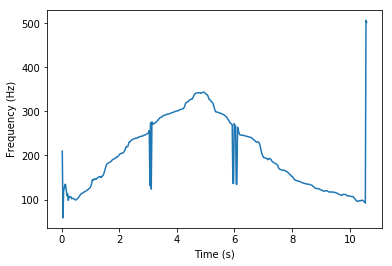

In [25]:
wegg = aud.get_channel_data(egg_channel_number,t_start=reg['start'],t_end=reg['end'])
pve = PV(wegg,sr,nfft=2**11,hop=2**10,pkthresh=1e-7)
pve.run_pv()
f0=pve.calc_f0()
t=pve.get_time_vector()
pl.figure()
pl.plot(t,f0)
pl.xlabel('Time (s)')
pl.ylabel('Frequency (Hz)')

## extract the calibration matrix

from the impedance measurement paramter object. This can usually be extracted from a measurement file as well, but should match the matrix in `calib/MeasurementParameters.mat`

`calibfvec` contains the frequencies corresponding to each of the matrices in `calibmx` $C(f)$

$$\left[\begin{matrix} \mu_1(f)\\ \mu_2(f)\end{matrix}\right] =  C(f) \left[\begin{matrix} p(f)\\ u(f)\end{matrix}\right]$$

where $\mu_1(f)$ and $\mu_2(f)$ are the two microphone complex amplitudes at a given frequency

In [26]:
calibmx = imp_params.A
calibfvec = imp_params.frequency_vector
calibmx.shape

(2, 2, 364)

## Calculate acoutic variables

`pvec` and `uvec` are the complex amplitudes of pressure and flow at the refence plane at the fundamental frequency.

When plotted against the corresponding frequency, they should trace the impedance of the long pipe + impedance head, as seen from the reference plane.

They are calculated by solving the linear system using the calibration matrix and the microphone complex amplitudes. Since the frequencies of the glide signal do not match the frequencies at which the impedance matrix was measured, we calculate using the matrix just above and just below, and then intrpolate the reult.

`pglot` and `uglot` are the complex amplitudes at the glottis, backpropagated from `pvec` and `uvec`. They should trace the impedance as seen from the glottis

They are obtained by multiplying the reference plane variables by the transfer matrix of the fitte vocal tract.

In [27]:
pvec = np.zeros(f0.shape, dtype='complex')
uvec = np.zeros(f0.shape, dtype='complex')

pglot = np.zeros(f0.shape, dtype='complex')
uglot = np.zeros(f0.shape, dtype='complex')

# these were used for the backpropagation using a straight pipe
dist = 0.17
c=345.0

# Characteristic impedances 
zc_head = psyn.StraightDuct(length=0.3,radius=0.013).char_impedance
zc_glot = vt.elements[0].char_impedance

for ii in range(pva[0].f.shape[0]):
    # frequency of the glide at this frame
    fi = f0[ii]
    # calculate the complex amplitudes of microphone signals
    # from the PV analysis
    camps = []
    for mic_no in range(len(pva)):
        pv = pva[mic_no]
        idxpv = np.argmin(np.abs(pv.f[ii,:]-fi))
        camps.append(pv.mag[ii,idxpv] * np.exp(1j*pv.ph[ii,idxpv]))
    try:
        # apply the calibration matrix above and below the glide frequency
        calibidxl = np.flatnonzero(calibfvec-fi < 0)[-1]
        calibidxr = np.flatnonzero(calibfvec-fi > 0)[0]
        calibidxs = [calibidxl, calibidxr]
        pulr = []
        flr = []
        for cidx in calibidxs:
            aa = np.linalg.inv(calibmx[:,:,cidx])
            pu = np.matmul(aa,camps)
            pulr.append(pu)
            flr.append(calibfvec[cidx])
        # pulr contains pressure and flow approximations at calibration frequencies 
        # above and below the glide frequency
        pulr=np.array(pulr)
        # now we interpolate the two results
        pvec[ii] = np.interp(fi,flr,pulr[:,0])
        # minus sign here is because the head has been calibrated to measure
        # flow going towards the mouth. If looking towards the long pipe
        # flow has to be reversed
        uvec[ii] = -np.interp(fi,flr,pulr[:,1])/zc_head
        
        ## backpropagation
        k = 2*np.pi*fi/c
        kl = -k*dist
        # next line for a straight duct packpropagation
        #backpropmx = np.array([[np.cos(kl), -1j*np.sin(kl)],[-1j*np.sin(kl), np.cos(kl)]])
        
        # get the transfer matrix at the glide frequency
        backpropmx = vt.transfer_mx_at_freq(fi).squeeze()
        # invert and multiply to get variables at glottis
        backpropmx = np.linalg.inv(backpropmx)
        pug = np.matmul(backpropmx,np.array([pvec[ii],uvec[ii]]))
        pglot[ii] = pug[0]
        uglot[ii] = pug[1]*zc_glot
    except IndexError:
        pass

## Impedance plots 

Top graph should trace the impedance of the long pipe

This usually works well, I don't know why it's not working here... Check the other two notebooks.

/home/goios/Envs/unsw/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/goios/Envs/unsw/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


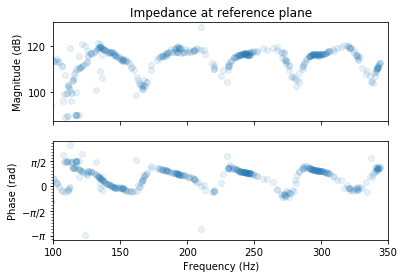

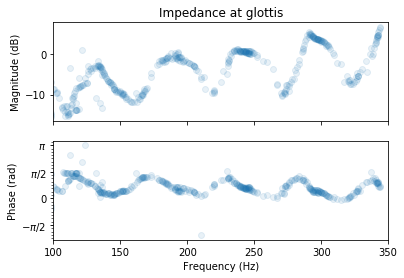

In [28]:
fig,ax=bodeplot(f0,pvec/uvec,marker='o',lw=0,alpha=.1)
pl.xlim(100,350)
ax[0].set_title('Impedance at reference plane');
#pl.tight_layout()
fig,ax=bodeplot(f0,pglot/uglot,marker='o',lw=0,alpha=.1)
pl.xlim(100,350)
ax[0].set_title('Impedance at glottis');
#pl.tight_layout()